In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D
import time
import numpy as np
from keras.callbacks import EarlyStopping
import multiprocessing

In [2]:
workers = multiprocessing.cpu_count()

sdir=r'archive\Image Data base\Image Data base'
min_samples= 300 # set limit for minimum images a class must have to be included in the dataframe
filepaths = []
labels=[]

In [3]:
def filter_data(sdir, min_samples, filepaths, labels):
    classlist=os.listdir(sdir)   
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        flist=os.listdir(classpath)
        if len(flist) >= min_samples:
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        else:
            print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')


def holdout(filepaths, labels):
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    df=pd.concat([Fseries, Lseries], axis=1)


    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels'])

    valid_df, test_df=train_test_split(dummy_df, train_size=.33, shuffle=True, random_state=123, stratify=dummy_df['labels'])

    print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return (train_df, valid_df, test_df)


In [4]:
filter_data(sdir, min_samples, filepaths, labels)

class  Bacterial leaf blight in rice leaf  has only 120  samples and will not be included in dataframe
class  Brown spot in rice leaf  has only 120  samples and will not be included in dataframe
class  cabbage looper  has only 234  samples and will not be included in dataframe
class  Cercospora leaf spot  has only 189  samples and will not be included in dataframe
class  Garlic  has only 147  samples and will not be included in dataframe
class  ginger  has only 135  samples and will not be included in dataframe
class  healthy tea leaf  has only 222  samples and will not be included in dataframe
class  Leaf smut in rice leaf  has only 120  samples and will not be included in dataframe
class  lemon canker  has only 183  samples and will not be included in dataframe
class  Nitrogen deficiency in plant  has only 33  samples and will not be included in dataframe
class  onion  has only 60  samples and will not be included in dataframe
class  potassium deficiency in plant  has only 54  sample

In [5]:
train_df, valid_df, test_df = holdout(filepaths, labels)

train_df lenght:  138314   test_df length:  39717   valid_df length:  19561


In [6]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]

for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]

print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

The number of classes in the dataset is:  41
            CLASS               IMAGE COUNT 
       Apple Apple scab            4234     
       Apple Black rot             4175     
    Apple Cedar apple rust         1848     
        Apple healthy              2764     
     Blight in corn Leaf           2407     
      Blueberry healthy            2524     
Cherry (including sour) Powdery mildew     1768     
Cherry (including_sour) healthy     1436     
   Common Rust in corn Leaf        2743     
     Corn (maize) healthy          1953     
       Grape Black rot             7930     
   Grape Esca Black Measles        9299     
Grape Leaf blight Isariopsis Leaf Spot     7232     
        Grape healthy               712     
 Gray Leaf Spot in corn Leaf       1205     
Orange Haunglongbing Citrus greening     37010    
        Peach healthy               605     
  Pepper bell Bacterial spot       2092     
     Pepper bell healthy           2484     
     Potato Early blight        

In [7]:
# lets get the average height and width of a sample of the train images
ht=0
wt=0

# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)

for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]

print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

average height=  256  average width=  259 aspect ratio=  0.9884526558891455


In [8]:
# Definindo tamanho do batch e tamanho da imagem
batch_size = 32
img_size = (224, 224)

# Criando geradores de imagens para treinamento e validação
train_gen = ImageDataGenerator(
    horizontal_flip=True, 
    rotation_range=20, 
    width_shift_range=.2,
    height_shift_range=.2, 
    zoom_range=.2
).flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size,
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_gen = ImageDataGenerator().flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size,
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

Found 138314 validated image filenames belonging to 41 classes.
Found 19561 validated image filenames belonging to 41 classes.


In [9]:
# Calculando tamanho do batch para conjunto de teste
length = len(test_df)
test_batch_size = 32
test_steps = int(length / test_batch_size)

# Criando gerador de imagens para teste
test_gen = ImageDataGenerator().flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size,
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size
)

Found 39717 validated image filenames belonging to 41 classes.


In [10]:
# Obtendo informações relevantes dos geradores
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels


# Imprimindo informações úteis
print('test batch size: ', test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

img_shape=(img_size[0], img_size[1], 3)
epocas = 150

# Define o modelo base

base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False,
    input_shape=img_shape,
    pooling='max')

# Adiciona camadas adicionais para adaptação ao conjunto de dados
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)

test batch size:  32   test steps:  1241  number of classes :  41


In [11]:
predictions = Dense(class_count, activation='softmax')(x)

# Define o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congela as camadas do modelo base para que não sejam treinadas durante o treinamento
for layer in base_model.layers:
    layer.trainable = False

# Compila o modelo com uma função de perda e um otimizador
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#define o earlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=(epocas*0.1), verbose=1)

# Treina o modelo
incecption_trained = model.fit(train_gen, validation_data=valid_gen, epochs=epocas, callbacks=[earlystop], workers = workers)

# Salva o modelo treinado em um arquivo local
model.save('inceptionV2_model_trained.h5')

# Avalia o modelo no conjunto de teste
y_prev = model.evaluate(test_gen)

Epoch 1/150
4323/4323 [==============================] - 320s 72ms/step - loss: 2.0555 - accuracy: 0.4768 - val_loss: 1.6017 - val_accuracy: 0.5448
Epoch 2/150
4323/4323 [==============================] - 288s 66ms/step - loss: 1.6163 - accuracy: 0.5355 - val_loss: 1.4603 - val_accuracy: 0.5819
Epoch 3/150
4323/4323 [==============================] - 278s 64ms/step - loss: 1.5356 - accuracy: 0.5543 - val_loss: 1.4319 - val_accuracy: 0.5819
Epoch 4/150
4323/4323 [==============================] - 339s 78ms/step - loss: 1.4861 - accuracy: 0.5671 - val_loss: 1.3815 - val_accuracy: 0.5924
Epoch 5/150
4323/4323 [==============================] - 332s 77ms/step - loss: 1.4601 - accuracy: 0.5724 - val_loss: 1.3323 - val_accuracy: 0.6116
Epoch 6/150
4323/4323 [==============================] - 275s 64ms/step - loss: 1.4373 - accuracy: 0.5791 - val_loss: 1.3011 - val_accuracy: 0.6119
Epoch 7/150
4323/4323 [==============================] - 271s 63ms/step - loss: 1.4095 - accuracy: 0.5852 - val_

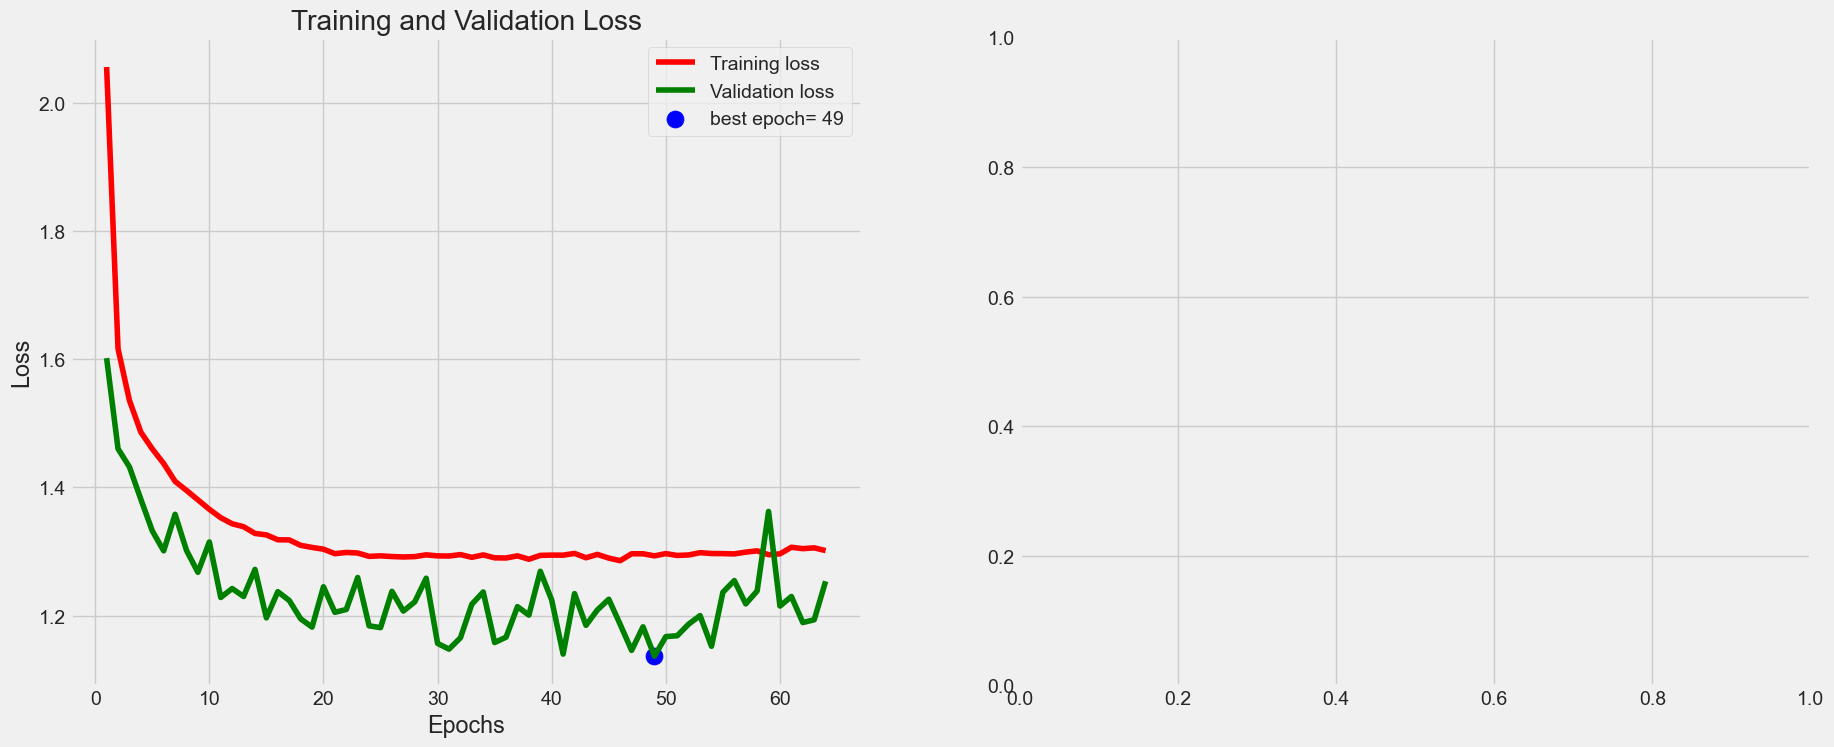

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(incecption_trained,0)